In [393]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [394]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [395]:
ALPHABET_SIZE = 27
all_chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(all_chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [396]:
BLOCK_SIZE = 3
def build(words):
    X = []
    Y = []
    for word in words:
        context = [0] * BLOCK_SIZE
        for letter in word + '.':
            letter_index = stoi[letter]
            X.append(context[:])
            Y.append(letter_index)
            context = context[1:] + [letter_index]
    return torch.tensor(X), torch.tensor(Y)

In [397]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_train, Y_train = build(words[:n1])
X_valid, Y_valid = build(words[n1:n2])
X_test, Y_test = build(words[n2:])

In [398]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBEDDING_SIZE = 20
C = torch.randn((ALPHABET_SIZE, EMBEDDING_SIZE), generator=g, requires_grad=True)

In [399]:
HIDDEN_SIZE = 500
W1 = torch.randn((BLOCK_SIZE * EMBEDDING_SIZE, HIDDEN_SIZE), generator=g) * 0.1
b1 = torch.randn((HIDDEN_SIZE), generator=g) * 0.01

W2 = torch.randn((HIDDEN_SIZE, ALPHABET_SIZE), generator=g) * 0.01
b2 = torch.randn((ALPHABET_SIZE), generator=g) * 0

batchnorm_gain = torch.ones((1, HIDDEN_SIZE))
batchnorm_bias = torch.zeros((1, HIDDEN_SIZE))
batchnorm_mean_running = torch.zeros((1, HIDDEN_SIZE))
batchnorm_std_running = torch.ones((1, HIDDEN_SIZE))

In [400]:
parameters = [C, W1, b1, W2, b2, batchnorm_gain, batchnorm_bias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

45567


In [401]:
def step(X, Y, step_count):
    batch_size = 128
    idxs = torch.randint(0, X.shape[0], (batch_size,))
    X_batch = X[idxs]
    Y_batch = Y[idxs]

    # forward pass
    embeddings = C[X_batch]
    hidden_output_pre = embeddings.view(-1, BLOCK_SIZE * EMBEDDING_SIZE) @ W1 + b1
  

    # let's batch normalize here
    mean = hidden_output_pre.mean(dim=0, keepdim=True)
    std = hidden_output_pre.std(dim=0, keepdim=True)
    hidden_output_pre = batchnorm_gain * (hidden_output_pre - mean) / std + batchnorm_bias

    with torch.no_grad():
        global batchnorm_mean_running, batchnorm_std_running
        batchnorm_mean_running = batchnorm_mean_running * 0.9 + mean * 0.1
        batchnorm_std_running = batchnorm_std_running * 0.9 + std * 0.1

    hidden_output = hidden_output_pre.tanh()
    output = hidden_output @ W2 + b2

    loss = F.cross_entropy(output, Y_batch)

    # backward pass
    for param in parameters:
        param.grad = None
    loss.backward()

    # update parameters
    learning_rate = 0.1 if step_count < 100000 else 0.01
    for param in parameters:
        param.data += -learning_rate * param.grad
    return loss.item(), hidden_output, hidden_output_pre



In [402]:
stepi = []
lossi = []

step 100, loss 2.528710
step 200, loss 2.312791
step 300, loss 2.376752
step 400, loss 2.351661
step 500, loss 2.229455
step 600, loss 2.393625
step 700, loss 2.318513
step 800, loss 2.216207
step 900, loss 2.343251
step 1000, loss 2.246161
step 1100, loss 2.352484
step 1200, loss 2.287546
step 1300, loss 2.225737
step 1400, loss 2.308115
step 1500, loss 2.194474
step 1600, loss 2.306106
step 1700, loss 2.287034
step 1800, loss 2.373147
step 1900, loss 2.189312
step 2000, loss 2.158216
step 2100, loss 2.519608
step 2200, loss 2.280829
step 2300, loss 2.273566
step 2400, loss 2.192097
step 2500, loss 2.420304
step 2600, loss 2.050746
step 2700, loss 2.213014
step 2800, loss 2.196010
step 2900, loss 2.146174
step 3000, loss 2.171899
step 3100, loss 2.119732
step 3200, loss 2.163828
step 3300, loss 1.994581
step 3400, loss 2.123010
step 3500, loss 2.021263
step 3600, loss 2.209020
step 3700, loss 2.104397
step 3800, loss 2.150856
step 3900, loss 2.152803
step 4000, loss 2.321115
step 4100

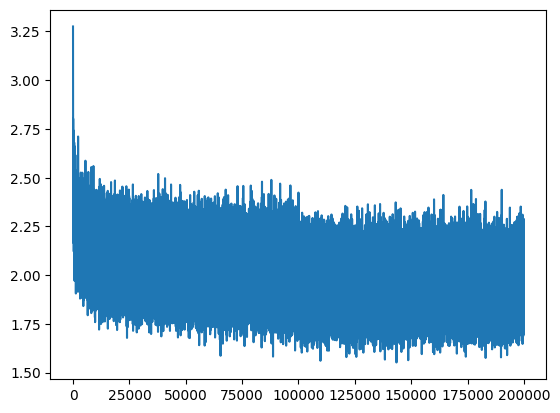

In [403]:
for i in range(200_000):
    stepi.append(len(stepi) + 1)
    loss, h, hpre = step(X_train, Y_train, stepi[-1])
    if stepi[-1] % 100 == 0:
        print("step %d, loss %f" % (stepi[-1], loss))
    lossi.append(loss)

plt.plot(stepi, lossi)

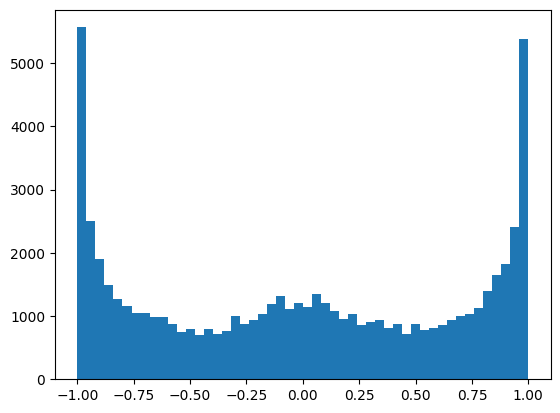

In [404]:
plt.hist(h.view(-1).detach().numpy(), 50)
plt.show()

(array([1.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 1.300e+01, 1.700e+01,
        2.200e+01, 5.500e+01, 5.800e+01, 1.070e+02, 1.740e+02, 2.490e+02,
        3.540e+02, 4.920e+02, 6.750e+02, 9.090e+02, 1.214e+03, 1.606e+03,
        1.884e+03, 2.398e+03, 2.697e+03, 3.411e+03, 3.865e+03, 4.585e+03,
        7.438e+03, 7.265e+03, 4.829e+03, 3.724e+03, 3.195e+03, 2.971e+03,
        2.347e+03, 1.816e+03, 1.408e+03, 1.137e+03, 9.420e+02, 7.290e+02,
        4.440e+02, 3.510e+02, 2.270e+02, 1.540e+02, 8.500e+01, 6.000e+01,
        3.800e+01, 1.900e+01, 1.000e+01, 9.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00]),
 array([-6.76436710e+00, -6.49354696e+00, -6.22272635e+00, -5.95190620e+00,
        -5.68108559e+00, -5.41026545e+00, -5.13944483e+00, -4.86862469e+00,
        -4.59780407e+00, -4.32698393e+00, -4.05616331e+00, -3.78534317e+00,
        -3.51452279e+00, -3.24370241e+00, -2.97288203e+00, -2.70206165e+00,
        -2.43124127e+00, -2.16042089e+00, -1.88960063e+00, -1.61878026e+

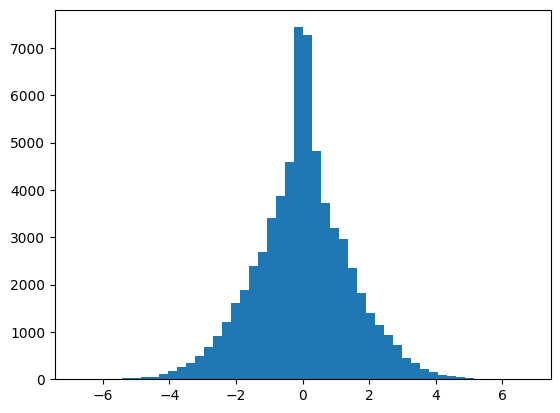

In [405]:
plt.hist(hpre.view(-1).detach().numpy(), bins=50)

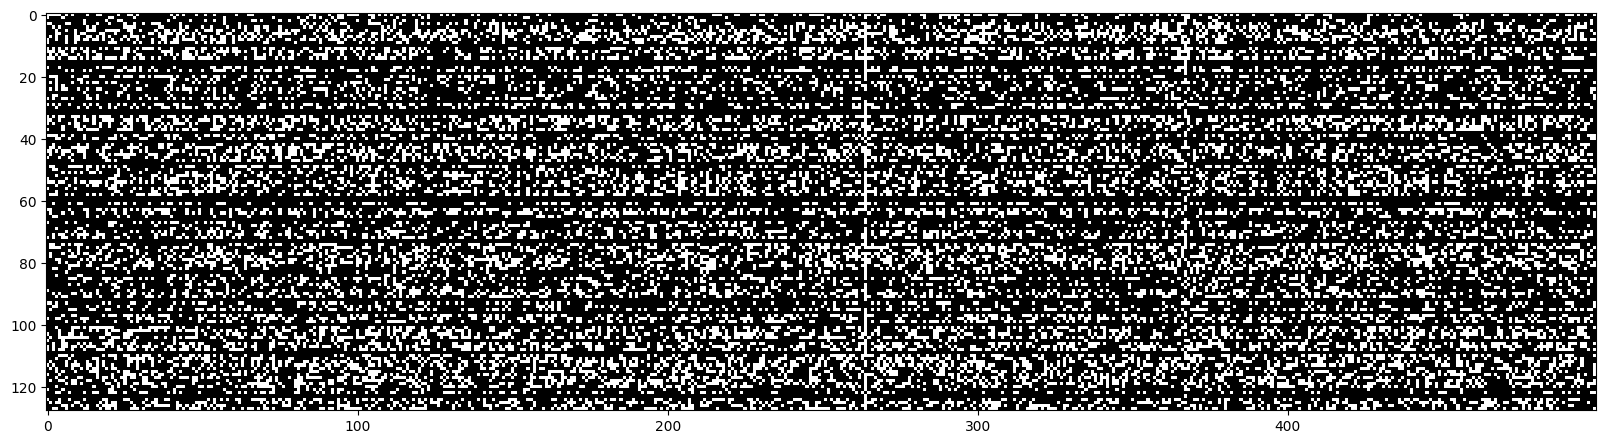

In [406]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.9, cmap='gray', interpolation='nearest')

In [407]:
def calculate_loss(X, Y):
    with torch.no_grad():
        embeddings = C[X]
        hidden_outputs = (embeddings.view(-1, EMBEDDING_SIZE * BLOCK_SIZE) @ W1 + b1)
        # batch norm
        hidden_outputs = batchnorm_gain * (hidden_outputs - batchnorm_mean_running) / batchnorm_std_running + batchnorm_bias
        hidden_outputs = hidden_outputs.tanh()
        outputs = hidden_outputs @ W2 + b2
        loss = F.cross_entropy(outputs, Y)
        print(loss.item())

In [408]:
calculate_loss(X_train, Y_train)
calculate_loss(X_valid, Y_valid)
calculate_loss(X_test, Y_test)

1.935746192932129
2.0705809593200684
2.071641683578491


### with uniform random weights 

* training data: 2.093881368637085
* validation data: 2.12778377532959
* test data: 2.1320531368255615

### with zero weights initially

* training data: 2.093501091003418
* validation data: 2.1362602710723877
* test data: 2.1324846744537354

### After batchnorm

* training data: 2.058980941772461
* validation data: 2.1095173358917236
* test data: 2.105339765548706